# Location detection

The task is to detect location names from ukrainian and russian texts.

In [1]:
%matplotlib inline

import os
import re
import spacy
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, GroupKFold
from sklearn.metrics import precision_recall_curve, auc
from torch import nn
from torchtext.vocab import build_vocab_from_iterator
import gensim.downloader
from gensim.models import Word2Vec
import string

In [2]:
global_device = 'cpu'

if torch.cuda.is_available():
    global_device = 'cuda'

DATA_DIR = "../data/location_detection/"

## Load data

In [ ]:
uk_dataset = pd.read_csv(DATA_DIR + "uk_geo_dataset.csv", converters={'loc_markers': eval})
ru_dataset = pd.read_csv(DATA_DIR + "ru_geo_dataset.csv", converters={'loc_markers': eval})

In [ ]:
uk_dataset.head()

In [ ]:
ru_dataset.head()

## EDA

In [ ]:
uk_dataset['location_count'] = uk_dataset['loc_markers'].apply(len)
ru_dataset['location_count'] = ru_dataset['loc_markers'].apply(len)

In [ ]:
def get_locations(row):
    text, loc_markers = row['text'], row['loc_markers']
    return [text[s:e] for s, e in loc_markers]

print(uk_dataset[uk_dataset['location_count'] >= 1].iloc[1]['text'])
print(get_locations(uk_dataset[uk_dataset['location_count'] >= 1].iloc[1]))
print(ru_dataset.iloc[1]['text'])
print(get_locations(ru_dataset.iloc[1]))

In [ ]:
uk_dataset.shape[0]

In [ ]:
ru_dataset.shape[0]

In [ ]:
fig, (uk_dist, ru_dist) = plt.subplots(1, 2, figsize=(15, 5))

uk_dist.title.set_text('Uk dataset location count distribution')
uk_dist.plot(uk_dataset['location_count'].value_counts(normalize=True))

ru_dist.title.set_text('Ru dataset location count distribution')
ru_dist.plot(ru_dataset['location_count'].value_counts(normalize=True))
plt.show()

print("Uk_dataset:")
print(uk_dataset['location_count'].value_counts())
print("Ru_dataset:")
ru_dataset['location_count'].value_counts()

In [ ]:
locations = uk_dataset.apply(get_locations, axis=1)

result = []
for x in locations.to_list():
    for l in x:
        result.append(l)

pd.Series(result).value_counts()

In [ ]:
ru_dataset['doc_id'].value_counts()

## Evaluation

Using metric function from kaggle competition:

In [3]:
def process_text(text):
    text = re.sub(r'[{re.escape(string.punctuation)}]', '', text)
    text = re.sub(r'\d', '', text)
    text = re.sub(r'\b\w\b\s?]', '', text)
    text = re.sub(r'\s+', ' ', text)
    return text.lower()

def metric(y_true, y_pred):
    assert len(y_true) == len(y_pred)
    tp, fp, fn, p = 0.0, 0.0, 0.0, 0.0

    for y_true_sample, y_pred_sample in zip(y_true, y_pred):
        y_true_sample = set([process_text(s) for s in y_true_sample])
        y_pred_sample = set([process_text(s) for s in y_pred_sample])

        tp += len(y_true_sample & y_pred_sample)
        fp += len(y_pred_sample - y_true_sample)
        fn += len(y_true_sample - y_pred_sample)
        p += len(y_true_sample)

    if tp + fp == 0:
        if p == 0:
            precision = 1.0
        else:
            precision = 0.0
    else:
        precision = tp/(tp + fp)

    if tp + fn == 0:
        if p == 0:
            recall = 1.0
        else:
            recall = 0.0
    else:
        recall = tp/(tp+fn)

    if precision + recall == 0:
        f1 = 0.0
    else:
        f1 = 2*precision*recall/(precision+recall)
        
    return {
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

## Data preparation

To mark loaction using two tokens: begining of location (B-LOC) and inside of location (I-LOC).

This is necesary, because with using only one LOC token two different locations and one location with two words in it would look the same.

In [4]:
nlp = spacy.load('uk_core_news_sm', disable=['tagger', 'parser', 'ner', 'texcat'])

def tokenize(texts, all_texts_loc_markers, tokenizer, batch_size=128, n_process=-1):
    all_texts_tokenized = list(tokenizer.pipe(texts, batch_size=batch_size, n_process=n_process))

    result_tokens = []
    result_labels = []
    for tokenized_text, loc_markers in zip(all_texts_tokenized, all_texts_loc_markers):
        tokens = [token.text for token in tokenized_text]
        labels = ['O'] * len(tokenized_text)

        for idx, token in enumerate(tokenized_text):
            for start, end in loc_markers:
                if token.idx >= start and token.idx + len(token.text) <= end:
                    if token.idx == start:
                        # If token start pos == marker start,
                        # then it is begining of new location name
                        labels[idx] = 'B-LOC'
                    else:
                        # If token start pos > marker start,
                        # then it is inside of location name
                        labels[idx] = 'I-LOC'
        result_tokens.append(tokens)
        result_labels.append(labels)
        
    return result_tokens, result_labels

In [5]:
def process_dataset(dataset, result_path, add_col, n_splits=100):
    try:
        os.remove(result_path)
    except OSError:
        pass
    
    for split in tqdm(np.array_split(dataset, n_splits), total=n_splits, bar_format='{l_bar}{bar:100}{r_bar}'):
        tokens, labels = tokenize(split['text'].to_list(), split['loc_markers'].to_list(), nlp)
        result_df = pd.DataFrame({'tokens': tokens, 'labels': labels, add_col: split[add_col].to_list()})
        if not os.path.isfile(result_path):
            result_df.to_parquet(result_path, engine='fastparquet')
        else:
            result_df.to_parquet(result_path, engine='fastparquet', append=True)

In [6]:
# process_dataset(uk_dataset, DATA_DIR + 'uk_geo_dataset_processed.parquet', 'is_valid')
# del uk_dataset

In [7]:
# process_dataset(ru_dataset.sample(frac=0.1), DATA_DIR + 'ru_geo_dataset_processed.parquet', 'doc_id')
# del ru_dataset

In [8]:
uk_processed_dataset_df = pd.read_parquet(DATA_DIR + 'uk_geo_dataset_processed.parquet', engine='fastparquet')
ru_processed_dataset_df = pd.read_parquet(DATA_DIR + 'ru_geo_dataset_processed.parquet', engine='fastparquet')

In [9]:
uk_processed_dataset_df[10:20]

,tokens,labels,is_valid
10,"[Піар, був, відповідним, ,, не, гребували, ніч...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",0
11,"[Адже, кожна, маска, з, ручною, вишивкою, хрес...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",0
12,"[До, того, ж, це, стане, додатковим, поштовхом...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",0
13,"[Подібні, розіграші, проводили, в, Великій, Бр...","[O, O, O, O, B-LOC, I-LOC, O]",0
14,"["", Це, неприпустимий, безпрецедентний, випадо...","[O, O, O, O, O, O, O, O, O, O, O]",0
15,"[У, вас, стільки, знайомих, ,, друзів, ,, прия...","[O, O, O, O, O, O, O, O, O]",0
16,"[У, Львові, 34-річний, мешканець, Яворівськог...","[O, B-LOC, O, O, B-LOC, I-LOC, O, O, O, O, O, ...",0
17,"[Ось, як, отримати, гарний, врожай, баклажанів...","[O, O, O, O, O, O, O]",0
18,"[У., Т., :, Хто, чи, що, може, змінити, маніпу...","[O, O, O, O, O, O, O, O, O, O, O, O]",0
19,"[Проказа, популізму, -, Міжнародна, політика, ...","[O, O, O, O, O, O, O, O]",0


In [10]:
ru_processed_dataset_df[10:20]

,tokens,labels,doc_id
10,"[Однако, их, производство, весьма, дорого, .]","[O, O, O, O, O, O]",472973
11,"[Столешница, выполнена, из, стекла, .]","[O, O, O, O, O]",116962
12,"[По, его, мнению, ,, подобный, шаг, может, под...","[O, O, O, O, O, O, O, O, B-LOC, O, O, O, O, O,...",83933
13,"[По, словам, министра, ,, он, относится, к, эт...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",591997
14,"[Кроме, того, ,, у, Кремля, появился, шанс, ис...","[O, O, O, O, B-LOC, O, O, O, O, O, O, O, O, O,...",24448
15,"[Об, этом, ,, как, сообщает, корреспондент, «,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",108381
16,"[На, пост, ,, который, в, течение, предыдущих,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",508161
17,"[Он, руководил, департаментами, здравоохранени...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",479107
18,"[Новинка, поддерживает, работу, с, двумя, тюне...","[O, O, O, O, O, O, O, O]",587897
19,"[Из, его, экипажа, пока, удалось, спасти, лишь...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",532152


### Cross validations

Split dataset into train, test and validation.

Uk dataset will be stratified and ru dataset will be groupd by document id

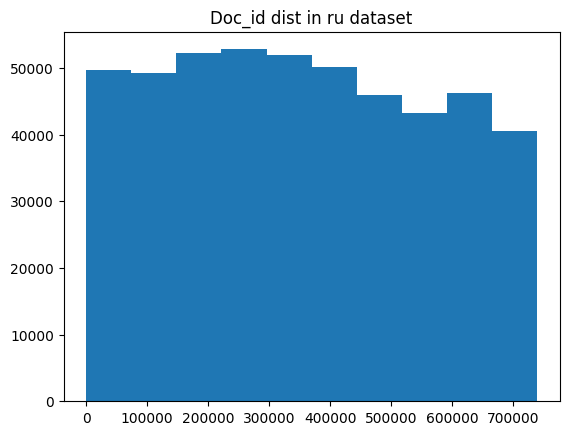

In [11]:
ru_doc_id_dist = ru_processed_dataset_df['doc_id'].value_counts()
plt.title("Doc_id dist in ru dataset")
plt.hist(dict(ru_doc_id_dist))
plt.show();

Examples in ru dataset with doc_id bigger then 700000 will be used as holdout

In [12]:
uk_train_processed_dataset, uk_holdout_processed_dataset = (
    uk_processed_dataset_df[uk_processed_dataset_df['is_valid'] == False].reset_index(drop=True),
    uk_processed_dataset_df[uk_processed_dataset_df['is_valid'] == True].reset_index(drop=True)
)
ru_train_processed_dataset, ru_holdout_processed_dataset = (
    ru_processed_dataset_df[ru_processed_dataset_df['doc_id'] < 700000].reset_index(drop=True),
    ru_processed_dataset_df[ru_processed_dataset_df['doc_id'] >= 700000].reset_index(drop=True)
)
len(ru_train_processed_dataset), len(ru_holdout_processed_dataset)

(772490, 30394)

Using fraction of train set to iterate faster:

In [13]:
# Comment for best model performance
uk_train_processed_dataset = uk_train_processed_dataset.sample(frac=0.01).reset_index(drop=True)
ru_train_processed_dataset = ru_train_processed_dataset.sample(frac=0.01).reset_index(drop=True)

In [14]:
def count_location(labels):
    locations = [1 for label in labels if label == 'B-LOC']
    return len(locations)

In [15]:
uk_train_processed_dataset['location_count'] = uk_train_processed_dataset['labels'].apply(count_location)
uk_train_processed_dataset['stratify_col'] = uk_train_processed_dataset['location_count']
uk_train_processed_dataset.loc[uk_train_processed_dataset['location_count'] >= 10, 'stratify_col'] = -1

In [16]:
skf = StratifiedKFold(n_splits=4, shuffle=True)
gkf = GroupKFold(n_splits=4)
uk_train_test_ids = [fold for fold in skf.split(uk_train_processed_dataset, uk_train_processed_dataset['stratify_col'])]
ru_train_test_ids = [fold for fold in gkf.split(ru_train_processed_dataset, groups=ru_train_processed_dataset['doc_id'])]

/home/mykyta/dev/study/nlp_course/homework/.env/lib/python3.11/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


### Torch dataset

Training two Word2Vec embeddors for uk and ru models on corresponding datasets:

In [17]:
uk_sentences = uk_train_processed_dataset['tokens'].to_numpy()
ru_sentences = ru_train_processed_dataset['tokens'].to_numpy()

uk_embeddor = Word2Vec(sentences=uk_sentences, vector_size=300, epochs=50)
ru_embeddor = Word2Vec(sentences=ru_sentences, vector_size=300, epochs=50)

In [18]:
class TextDataset(torch.utils.data.Dataset):
    def __init__(self, texts, targets, embeddor, output_length, pad_label='O', target_mapping={'O': [0, 0], 'B-LOC': [1, 0], 'I-LOC': [0, 1]}):
        self.texts = texts
        self.targets = targets
        self.embeddor = embeddor.wv
        self.output_length = output_length
        self.pad_label = pad_label
        self.target_mapping = target_mapping

    def __len__(self):
        return len(self.targets)

    def select_text_with_labels(self, text, labels):
        if len(text) == self.output_length:
            return (text, labels)

        if len(text) < self.output_length:
            diff = self.output_length - len(text)
            return (
                text + [""] * diff, # Pad with empty string, because tokenizer would remove it
                labels + [self.pad_label] * diff
            )

        if len(text) > self.output_length:
            return (text[:self.output_length], labels[:self.output_length])

    def embed(self, tokens):
        embeddings = []
        
        for token in tokens:
            if token in self.embeddor:
                embeddings.append(self.embeddor[token])
            else:
                # If embeddor doesn't know token return vector of zeros
                embeddings.append(np.zeros(self.embeddor.vector_size))

        return np.array(embeddings)
        
    def __getitem__(self, idx):
        tokens = self.texts[idx]
        labels = self.targets[idx]

        tokens, labels = self.select_text_with_labels(tokens, labels)

        embeddings = self.embed(tokens)
        labels = [self.target_mapping[label] for label in labels]
        return (
            torch.tensor(embeddings, dtype=torch.float32),
            torch.tensor(labels, dtype=torch.float32),
            torch.tensor(idx) # Return requested idx to decode used texts
        )

    def get_tokens(self, idx):
        tokens = self.texts[idx]
        labels = self.targets[idx]

        tokens, _ = self.select_text_with_labels(tokens, labels)
        
        return tokens

### Selecting output length

Using 0.95 quantile as SEQ_LEN to not lose many locations at the end of texts.

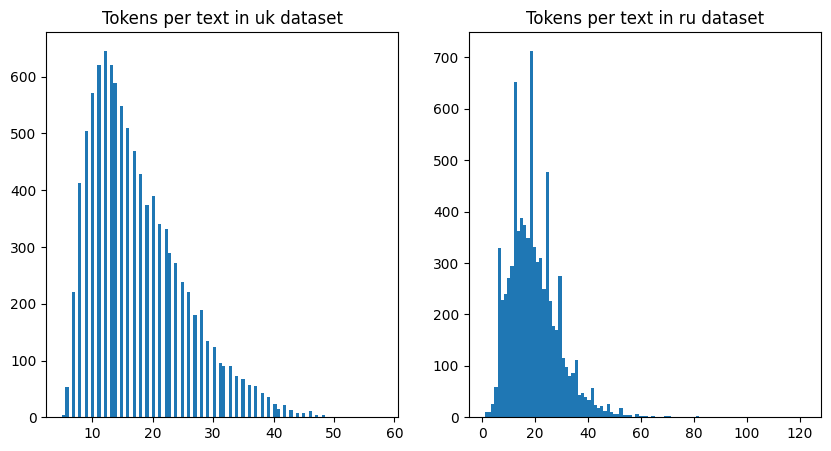

0.95 quantile of tokens per text uk dataset: 33, ru dataset: 37


In [19]:
uk_tokens_per_text = uk_train_processed_dataset['tokens'].apply(len)
ru_tokens_per_text = ru_train_processed_dataset['tokens'].apply(len)

fig, (uk_hist, ru_hist) = plt.subplots(1, 2, figsize=(10, 5))

uk_hist.title.set_text('Tokens per text in uk dataset')
uk_hist.hist(uk_tokens_per_text, bins=100)

ru_hist.title.set_text('Tokens per text in ru dataset')
ru_hist.hist(ru_tokens_per_text, bins=100)
plt.show()

UK_SEQ_LEN = int(np.quantile(uk_tokens_per_text, 0.95))
RU_SEQ_LEN = int(np.quantile(ru_tokens_per_text, 0.95))
print(f"0.95 quantile of tokens per text uk dataset: {UK_SEQ_LEN}, ru dataset: {RU_SEQ_LEN}")

## Modeling

Since Word2Vec is used, model doesn't need embedding layer.

I susspect that context is not too importan for this task and model doesn't need long term memory, so regular RNN should be fine.

Even if distant context is not very important, usefull information can still be in near words after current prediction, therefore RNN should be bidirectional.

Using ReLU for RNN to encreas learning speed.

Because BCEWithLogitsLoss is used as loss function, forward method doesn't apply sigmoid to model's predictions while training,
but pred method will apply sigmoid so model output would be between 0 and 1.

In [20]:
class RNN(nn.Module):
    def __init__(self, embed_dim, rnn_channels):
        super().__init__()

        self.rnns = nn.RNN(
            embed_dim,
            rnn_channels,
            bidirectional=True,
            num_layers=2,
            batch_first=True,
            nonlinearity='relu'
        )

        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(2 * rnn_channels, 2) # 2 output channels: one for B-LOC prob and another for I-LOC
        )

    def forward(self, x):
        x = self.rnns(x)[0]
        return self.classifier(x)

    def pred(self, x):
        """" Applyes sigmoid to predictions """
        x = self(x)
        x = self.classifier(x)
        return nn.functional.sigmoid(x)

In [21]:
def torch_loop(model, dataloader, optimizer, loss_fn, is_train=True, device='cpu'):
    if is_train:
        model.train()
    else:
        model.eval()

    predictions = []
    texts = []
    targets = []
    losses = []
    
    for embeddings, target, text_idx in tqdm(dataloader, total=len(dataloader), bar_format='{l_bar}{bar:100}{r_bar}'):
        embeddings, target = embeddings.to(device), target.to(device)
        
        if is_train:
            optimizer.zero_grad()
            
        pred = model(embeddings)
        
        loss = loss_fn(pred, target)

        if is_train:
            loss.mean().backward()
            optimizer.step()

        # Apply sigmoid to prediction so values were from 0 to 1
        pred_sig = nn.functional.sigmoid(pred)

        predictions.append(pred_sig.detach().cpu().numpy())
        texts.append(text_idx.detach().cpu().numpy())
        targets.append(target.detach().cpu().numpy())
        losses.append(loss.detach().cpu().numpy())

    predictions = np.concatenate(predictions)
    texts = np.concatenate(texts)
    targets = np.concatenate(targets)
    losses = np.concatenate(losses)
    
    return predictions, texts, targets, losses

In [22]:
def get_labels_from_predictions(pred, th=0.5):
    
    labels = np.zeros(pred[:, :, 0].shape)
    
    # Set 1 where model predicted B-LOC
    labels += (pred[:, :, 0] > th).astype(int)
    
    # Remove 1 label where model predicted both B-LOC and I-LOC > threshold
    labels *= -((pred[:, :, 1] > th).astype(int) - np.ones(pred[:, :, 1].shape))

    # Set 2 where model predicted I-LOC
    labels += 2 * (pred[:, :, 1] > th).astype(int)
    
    return labels

def extract_words(labels, tokens):
    # Remove empty labels
    texts = np.where(labels != 0, tokens, np.full(labels.shape, '<REM>'))
    extracted_texts = []
    extracted_labels = []
    for i in range(len(texts)):
        extracted_labels.append(labels[i][labels[i]!=0])
        extracted_texts.append(texts[i][texts[i]!='<REM>'])

    # Join connected tokens
    result = []
    for i in range(len(extracted_labels)):
        result.append([])
        if len(extracted_texts[i]) > 0:
            if extracted_labels[i][0] == 1:
                seq = [extracted_texts[i][0]]
            else:
                seq = [' ' + extracted_texts[i][0]]
            
            for w in range(1, len(extracted_labels[i])):
                if extracted_labels[i][w] == 1:
                    result[i].append(''.join(seq))
                    seq = [extracted_texts[i][w]]
                else:
                    seq.append(' ' + extracted_texts[i][w])

            # Append the last example
            result[i].append(''.join(seq))

    return result

def get_token_span(text, tokens):
    result = []
    last_index = 0
    for token in tokens:
        start_idx = text.find(token, last_index)
        if start_idx == -1:
            token.strip(string.punctuation)
            start_idx = text.find(token, last_index)
            
        if start_idx != -1:
            end_idx = start_idx + len(token)
            result.append((start_idx, end_idx - 1))
            last_index= end_idx
    return result

def get_decoded_texts(texts_ids, dataset):
    texts = []
    for text_id in texts_ids:
        texts.append(dataset.get_tokens(text_id))
    return texts

def decode(pred, texts_ids, dataset, th=0.5):
    pred_labels = get_labels_from_predictions(pred, th)
    
    texts = get_decoded_texts(texts_ids, dataset)
    
    return extract_words(pred_labels, texts), texts

def calc_metric(pred, true, texts_ids, dataset, th=0.5):
    pred_labels = get_labels_from_predictions(pred, th)
    true_labels = get_labels_from_predictions(true, 0.5)
    
    texts = get_decoded_texts(texts_ids, dataset)
    
    return metric(extract_words(true_labels, texts), extract_words(pred_labels, texts))

## Selecting hyperparams

In [23]:
def get_train_elements():
    model = RNN(
        300, # Word vector dims
        512
    ).to(global_device)
    
    loss_fn = nn.BCEWithLogitsLoss(reduction="none")
    optim = torch.optim.Adam(model.parameters(), lr=0.001)
    return model, optim, loss_fn

In [24]:
def getDataLoaders(dataset, fold, embeddor, output_length=25):
    train_ids, test_ids = fold
    
    train_torch_dataset = TextDataset(
        texts=dataset.iloc[train_ids]['tokens'].reset_index(drop=True),
        targets=dataset.iloc[train_ids]['labels'].reset_index(drop=True),
        embeddor=embeddor,
        output_length=output_length
    )
    train_dataloader = torch.utils.data.DataLoader(
        train_torch_dataset,
        batch_size=64,
        shuffle=True,
        drop_last=True
    )

    test_torch_dataset = TextDataset(
        texts=dataset.iloc[test_ids]['tokens'].reset_index(drop=True),
        targets=dataset.iloc[test_ids]['labels'].reset_index(drop=True),
        embeddor=embeddor,
        output_length=output_length
    )
    test_dataloader = torch.utils.data.DataLoader(
        test_torch_dataset,
        batch_size=64,
        shuffle=False,
        drop_last=False
    )

    return train_dataloader, train_torch_dataset, test_dataloader, test_torch_dataset

### Selecting epoch num and threshold
Since dataset is very imbalanced and f1 is depends on treshold, it is better to select epoch number based on presicion-recall auc and then select treshold.

In [25]:
def cv_epoch_stats(max_epoch_number, train_dataset, folds, embeddor, seq_len):
    
    epoch_fold_losses = [[] for _ in range(max_epoch_number)]
    epoch_fold_precision = [[] for _ in range(max_epoch_number)]
    epoch_fold_recall = [[] for _ in range(max_epoch_number)]
    epoch_fold_auc = [[] for _ in range(max_epoch_number)]
    epoch_fold_metric = [[] for _ in range(max_epoch_number)]
    epoch_fold_threshold = [[] for _ in range(max_epoch_number)]
    epoch_train_score = [[] for _ in range(max_epoch_number)]
    epoch_test_score = [[] for _ in range(max_epoch_number)]
    
    # Iterate over all cv folds
    for fold_i, fold in enumerate(folds):
        print(f'Fold {fold_i+1}:')
    
        # Generate dataloaders for cv fold
        train_dataloader, train_torch_dataset, test_dataloader, test_torch_dataset = getDataLoaders(train_dataset, fold, embeddor, output_length=seq_len)
    
        # Create new model for each fold
        model, optim, loss_fn = get_train_elements()
    
        # Train model of each fold over all epochs
        for epoch in range(max_epoch_number):
            _, _, _, train_loss = torch_loop(model, train_dataloader, optim, loss_fn, device=global_device)
            test_pred, test_texts, test_targets, test_loss = torch_loop(model, test_dataloader, optim, loss_fn, device=global_device, is_train=False)
    
            train_score = train_loss.mean()
            test_score = test_loss.mean()
            
            precision, recall, thresholds = precision_recall_curve(test_targets.flatten(), test_pred.flatten())

            div = (precision + recall)
            div[div == 0] = 0.01
            best_threshold_id = np.argmax(2 * precision * recall / div)
            best_threshold = thresholds[best_threshold_id]
                
            
            val_metric = calc_metric(test_pred, test_targets, test_texts, test_torch_dataset, th=best_threshold)
            auc_score = auc(recall, precision)
    
            # Save model score with model score on other folds at current epoch
            epoch_fold_losses[epoch].append(test_score)
            epoch_fold_precision[epoch].append(val_metric['precision'])
            epoch_fold_recall[epoch].append(val_metric['recall'])
            epoch_fold_auc[epoch].append(auc_score)
            epoch_fold_metric[epoch].append(val_metric['f1'])
            epoch_fold_threshold[epoch].append(best_threshold)

            epoch_train_score[epoch].append(train_score)
            epoch_test_score[epoch].append(test_score)
    
            print(f'Epoch {epoch + 1}:')
            print(f'Validation metric {val_metric}, used threshold: {best_threshold}')
            print(f'PR-AUC: {auc_score}, best thersold: {best_threshold}')
            print(f'Train loss: {train_score}, test loss: {test_score}')

    return epoch_fold_metric, epoch_fold_auc, epoch_fold_precision, epoch_fold_recall, epoch_fold_threshold, epoch_train_score, epoch_test_score

In [26]:
def print_stats(fold_metrics, fold_auc, fold_precisions, fold_recalls, fold_train_score, fold_test_score, title=''):
    
    avg_metric = [np.mean(epoch) for epoch in fold_metrics]
    avg_auc = [np.mean(epoch) for epoch in fold_auc]
    avg_precision = [np.mean(epoch) for epoch in fold_precisions]
    avg_recall = [np.mean(epoch) for epoch in fold_recalls]
    avg_train_score = [np.mean(epoch) for epoch in fold_train_score]
    avg_test_score = [np.mean(epoch) for epoch in fold_test_score]
    
    fig, ((f1_plot, auc_plot, train_test_plot), (auc_boxplot, precision_boxplot, recall_boxplot)) = plt.subplots(2, 3, figsize=(15, 7))

    fig.suptitle(title)
    fig.text(0.5, 0, "Epoch", ha="center")
    fig.text(0, 0.5, "Score", va="center", rotation="vertical")
    
    x_labels = range(1, len(avg_metric) + 1)
    
    # Avg f1 score plot
    f1_plot.title.set_text("Avg f1 score over epochs")
    f1_plot.plot(x_labels, avg_metric, label="f1")
    f1_plot.plot(x_labels, avg_precision, label="precision")
    f1_plot.plot(x_labels, avg_recall, label="recall")
    f1_plot.legend()
    
    # Avg auc score plot
    auc_plot.title.set_text("Avg PR-AUC score over epochs")
    auc_plot.plot(x_labels, avg_auc)
    
    # Train test plot
    train_test_plot.title.set_text("Train/test score")
    train_test_plot.plot(x_labels, avg_train_score, label="train score")
    train_test_plot.plot(x_labels, avg_test_score, label="test score")
    train_test_plot.legend()
    
    # Boxplots
    auc_boxplot.title.set_text("Auc folds score over epochs")
    precision_boxplot.title.set_text("Precision folds score over epochs")
    recall_boxplot.title.set_text("Recall folds score over epochs")
    auc_boxplot.boxplot(fold_auc, positions=x_labels)
    precision_boxplot.boxplot(fold_precisions, positions=x_labels)
    recall_boxplot.boxplot(fold_recalls, positions=x_labels);

In [27]:
print("CV for uk model")
(
    uk_fold_metrics,
    uk_fold_auc, 
    uk_fold_precisions,
    uk_fold_recalls,
    uk_fold_thresholds,
    uk_fold_train_score,
    uk_fold_test_score
) = cv_epoch_stats(5, uk_train_processed_dataset, uk_train_test_ids, uk_embeddor, UK_SEQ_LEN)

# Average PR-AUC at each epoch over all folds
uk_avg_auc = [np.mean(epoch) for epoch in uk_fold_auc]

CV for uk model
Fold 1:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 17.90it/s]


Epoch 1:
Validation metric {'precision': 0.5155763239875389, 'recall': 0.39593301435406697, 'f1': 0.4479025710419486}, used threshold: 0.12982021272182465
PR-AUC: 0.4084108165342398, best thersold: 0.12982021272182465
Train loss: 0.04289418086409569, test loss: 0.021029464900493622


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 17.68it/s]


Epoch 2:
Validation metric {'precision': 0.572289156626506, 'recall': 0.45454545454545453, 'f1': 0.5066666666666666}, used threshold: 0.3308364748954773
PR-AUC: 0.5007163391573677, best thersold: 0.3308364748954773
Train loss: 0.01837732270359993, test loss: 0.018179723992943764


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 17.74it/s]


Epoch 3:
Validation metric {'precision': 0.7005347593582888, 'recall': 0.4700956937799043, 'f1': 0.5626342161775233}, used threshold: 0.39194026589393616
PR-AUC: 0.5367070349437824, best thersold: 0.39194026589393616
Train loss: 0.01652519963681698, test loss: 0.017807263880968094


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 17.85it/s]


Epoch 4:
Validation metric {'precision': 0.6186440677966102, 'recall': 0.5239234449760766, 'f1': 0.5673575129533679}, used threshold: 0.23908917605876923
PR-AUC: 0.5642926562024556, best thersold: 0.23908917605876923
Train loss: 0.015313048847019672, test loss: 0.01732061244547367


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 17.35it/s]


Epoch 5:
Validation metric {'precision': 0.638728323699422, 'recall': 0.5287081339712919, 'f1': 0.5785340314136126}, used threshold: 0.31107014417648315
PR-AUC: 0.5869857892190378, best thersold: 0.31107014417648315
Train loss: 0.014042561873793602, test loss: 0.016268521547317505
Fold 2:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 17.68it/s]


Epoch 1:
Validation metric {'precision': 0.4377880184331797, 'recall': 0.4523809523809524, 'f1': 0.4449648711943794}, used threshold: 0.18107642233371735
PR-AUC: 0.3986043746125752, best thersold: 0.18107642233371735
Train loss: 0.04499531164765358, test loss: 0.020257141441106796


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 17.61it/s]


Epoch 2:
Validation metric {'precision': 0.5757071547420965, 'recall': 0.4119047619047619, 'f1': 0.48022206800832756}, used threshold: 0.17341139912605286
PR-AUC: 0.48992638663039867, best thersold: 0.17341139912605286
Train loss: 0.01859392412006855, test loss: 0.020311370491981506


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 17.05it/s]


Epoch 3:
Validation metric {'precision': 0.5674891146589259, 'recall': 0.4654761904761905, 'f1': 0.5114453891432308}, used threshold: 0.25633859634399414
PR-AUC: 0.5290617046753926, best thersold: 0.25633859634399414
Train loss: 0.016637522727251053, test loss: 0.01775834523141384


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 17.70it/s]


Epoch 4:
Validation metric {'precision': 0.5646437994722955, 'recall': 0.5095238095238095, 'f1': 0.5356695869837297}, used threshold: 0.3226023018360138
PR-AUC: 0.5304488310150939, best thersold: 0.3226023018360138
Train loss: 0.015430064871907234, test loss: 0.01761825941503048


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 17.61it/s]


Epoch 5:
Validation metric {'precision': 0.6428571428571429, 'recall': 0.4714285714285714, 'f1': 0.543956043956044}, used threshold: 0.40119749307632446
PR-AUC: 0.5565223868989186, best thersold: 0.40119749307632446
Train loss: 0.014456002041697502, test loss: 0.017049415037035942
Fold 3:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 17.41it/s]


Epoch 1:
Validation metric {'precision': 0.46553966189856955, 'recall': 0.4177362893815636, 'f1': 0.4403444034440344}, used threshold: 0.1910397857427597
PR-AUC: 0.4078577296197943, best thersold: 0.1910397857427597
Train loss: 0.043424949049949646, test loss: 0.019388040527701378


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 17.45it/s]


Epoch 2:
Validation metric {'precision': 0.5190355329949239, 'recall': 0.47724620770128356, 'f1': 0.49726443768996964}, used threshold: 0.2952830195426941
PR-AUC: 0.5053997918447656, best thersold: 0.2952830195426941
Train loss: 0.018706416711211205, test loss: 0.017854226753115654


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 17.94it/s]


Epoch 3:
Validation metric {'precision': 0.5886075949367089, 'recall': 0.4340723453908985, 'f1': 0.4996642041638684}, used threshold: 0.13994213938713074
PR-AUC: 0.5211978559295608, best thersold: 0.13994213938713074
Train loss: 0.01653526909649372, test loss: 0.01827344484627247


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 17.56it/s]


Epoch 4:
Validation metric {'precision': 0.5541125541125541, 'recall': 0.44807467911318555, 'f1': 0.4954838709677419}, used threshold: 0.144283264875412
PR-AUC: 0.5248411242061656, best thersold: 0.144283264875412
Train loss: 0.015308068133890629, test loss: 0.01775272563099861


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 17.17it/s]


Epoch 5:
Validation metric {'precision': 0.5790960451977402, 'recall': 0.47841306884480744, 'f1': 0.523961661341853}, used threshold: 0.2362447828054428
PR-AUC: 0.5537474112786318, best thersold: 0.2362447828054428
Train loss: 0.014325849711894989, test loss: 0.016880597919225693
Fold 4:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 17.07it/s]


Epoch 1:
Validation metric {'precision': 0.551433389544688, 'recall': 0.3847058823529412, 'f1': 0.45322245322245325}, used threshold: 0.2165629267692566
PR-AUC: 0.43684616850064084, best thersold: 0.2165629267692566
Train loss: 0.039339013397693634, test loss: 0.019707882776856422


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 17.68it/s]


Epoch 2:
Validation metric {'precision': 0.5986842105263158, 'recall': 0.42823529411764705, 'f1': 0.49931412894375854}, used threshold: 0.35363271832466125
PR-AUC: 0.5138676735314129, best thersold: 0.35363271832466125
Train loss: 0.018764713779091835, test loss: 0.017843112349510193


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 17.24it/s]


Epoch 3:
Validation metric {'precision': 0.5371794871794872, 'recall': 0.4929411764705882, 'f1': 0.5141104294478527}, used threshold: 0.23306098580360413
PR-AUC: 0.553660009745164, best thersold: 0.23306098580360413
Train loss: 0.016951140016317368, test loss: 0.016536004841327667


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 17.50it/s]


Epoch 4:
Validation metric {'precision': 0.6789297658862876, 'recall': 0.4776470588235294, 'f1': 0.5607734806629834}, used threshold: 0.19868573546409607
PR-AUC: 0.5810819710749203, best thersold: 0.19868573546409607
Train loss: 0.01582147926092148, test loss: 0.016656147316098213


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 17.54it/s]


Epoch 5:
Validation metric {'precision': 0.5948158253751705, 'recall': 0.5129411764705882, 'f1': 0.5508528111181301}, used threshold: 0.27208903431892395
PR-AUC: 0.5880547178843776, best thersold: 0.27208903431892395
Train loss: 0.014439599588513374, test loss: 0.016047636047005653


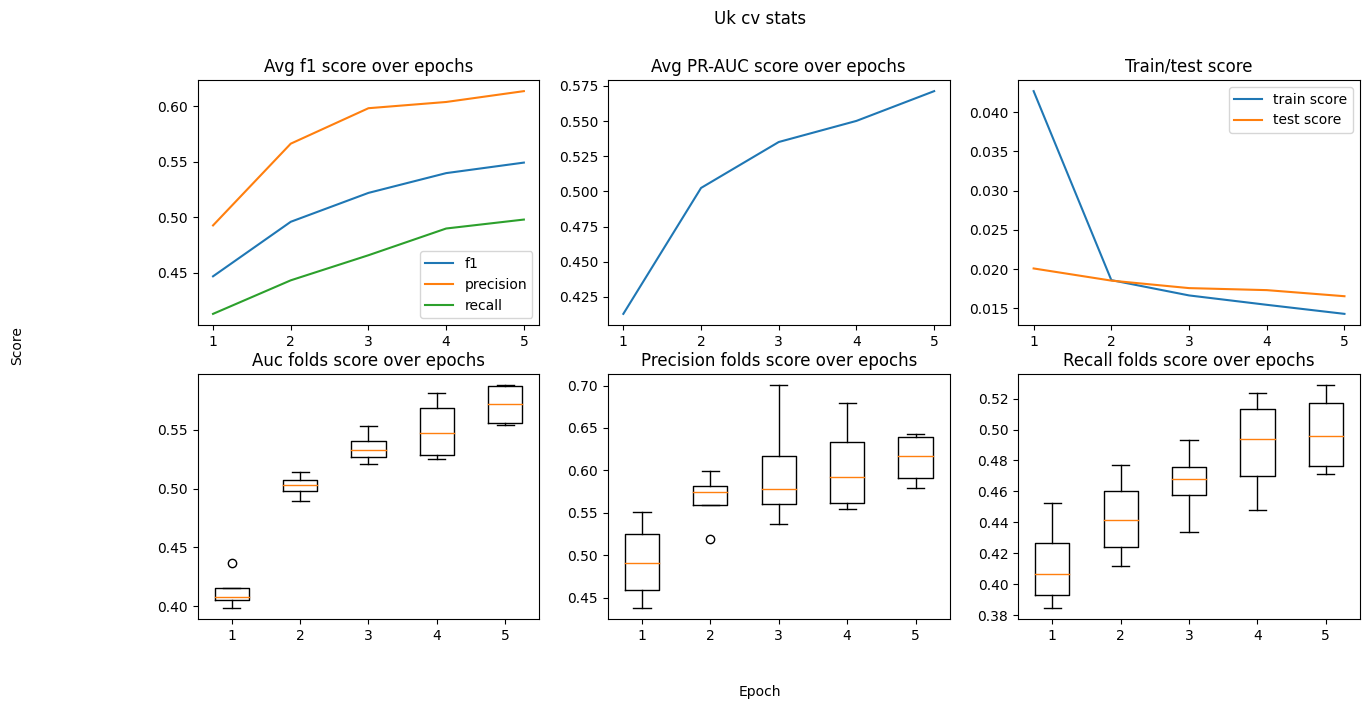

In [28]:
print_stats(uk_fold_metrics, uk_fold_auc, uk_fold_precisions, uk_fold_recalls, uk_fold_train_score, uk_fold_test_score, title='Uk cv stats')

In [29]:
print("CV for ru model")
(
    ru_fold_metrics,
    ru_fold_auc,
    ru_fold_precisions,
    ru_fold_recalls,
    ru_fold_thresholds,
    ru_fold_train_score,
    ru_fold_test_score,
) = cv_epoch_stats(5, ru_train_processed_dataset, ru_train_test_ids, ru_embeddor, RU_SEQ_LEN)

ru_avg_auc = [np.mean(epoch) for epoch in ru_fold_auc]

CV for ru model
Fold 1:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:01<00:00, 15.77it/s]


Epoch 1:
Validation metric {'precision': 0.45997973657548125, 'recall': 0.4855614973262032, 'f1': 0.47242455775234127}, used threshold: 0.18554404377937317
PR-AUC: 0.5191864570954412, best thersold: 0.18554404377937317
Train loss: 0.044661566615104675, test loss: 0.022569164633750916


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:02<00:00, 15.22it/s]


Epoch 2:
Validation metric {'precision': 0.5486338797814208, 'recall': 0.5368983957219251, 'f1': 0.5427027027027026}, used threshold: 0.16524653136730194
PR-AUC: 0.6174751371026161, best thersold: 0.16524653136730194
Train loss: 0.01896710880100727, test loss: 0.020119857043027878


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:01<00:00, 15.62it/s]


Epoch 3:
Validation metric {'precision': 0.668918918918919, 'recall': 0.5294117647058824, 'f1': 0.5910447761194031}, used threshold: 0.34577977657318115
PR-AUC: 0.6602820224750233, best thersold: 0.34577977657318115
Train loss: 0.016641583293676376, test loss: 0.01792164519429207


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:01<00:00, 15.60it/s]


Epoch 4:
Validation metric {'precision': 0.607795371498173, 'recall': 0.5336898395721925, 'f1': 0.5683371298405466}, used threshold: 0.2996257245540619
PR-AUC: 0.655303037971754, best thersold: 0.2996257245540619
Train loss: 0.015103287063539028, test loss: 0.018234780058264732


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:01<00:00, 15.70it/s]


Epoch 5:
Validation metric {'precision': 0.6715867158671587, 'recall': 0.5839572192513369, 'f1': 0.6247139588100686}, used threshold: 0.24051590263843536
PR-AUC: 0.6834379638678082, best thersold: 0.24051590263843536
Train loss: 0.01360202208161354, test loss: 0.018095603212714195
Fold 2:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:01<00:00, 15.60it/s]


Epoch 1:
Validation metric {'precision': 0.5183312262958281, 'recall': 0.4581005586592179, 'f1': 0.48635824436536185}, used threshold: 0.16591466963291168
PR-AUC: 0.5225672686951162, best thersold: 0.16591466963291168
Train loss: 0.04877454414963722, test loss: 0.021085821092128754


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:01<00:00, 15.58it/s]


Epoch 2:
Validation metric {'precision': 0.5746445497630331, 'recall': 0.5418994413407822, 'f1': 0.5577918343875791}, used threshold: 0.3205586075782776
PR-AUC: 0.6151045455027873, best thersold: 0.3205586075782776
Train loss: 0.019487764686346054, test loss: 0.018635140731930733


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:01<00:00, 16.00it/s]


Epoch 3:
Validation metric {'precision': 0.6632801161103048, 'recall': 0.5106145251396648, 'f1': 0.577020202020202}, used threshold: 0.2621888220310211
PR-AUC: 0.6427223402920657, best thersold: 0.2621888220310211
Train loss: 0.017120124772191048, test loss: 0.016979776322841644


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:01<00:00, 16.07it/s]


Epoch 4:
Validation metric {'precision': 0.6628498727735369, 'recall': 0.582122905027933, 'f1': 0.6198691255205234}, used threshold: 0.20802904665470123
PR-AUC: 0.6704202208394057, best thersold: 0.20802904665470123
Train loss: 0.015307373367249966, test loss: 0.01694304496049881


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:02<00:00, 14.67it/s]


Epoch 5:
Validation metric {'precision': 0.6993006993006993, 'recall': 0.5586592178770949, 'f1': 0.6211180124223602}, used threshold: 0.49515464901924133
PR-AUC: 0.6687404791306538, best thersold: 0.49515464901924133
Train loss: 0.013926230370998383, test loss: 0.016560934484004974
Fold 3:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:01<00:00, 15.84it/s]


Epoch 1:
Validation metric {'precision': 0.5167630057803468, 'recall': 0.5079545454545454, 'f1': 0.5123209169054441}, used threshold: 0.16959530115127563
PR-AUC: 0.5512616126185422, best thersold: 0.16959530115127563
Train loss: 0.04671680927276611, test loss: 0.020390376448631287


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:01<00:00, 15.89it/s]


Epoch 2:
Validation metric {'precision': 0.6105769230769231, 'recall': 0.5772727272727273, 'f1': 0.5934579439252337}, used threshold: 0.21892611682415009
PR-AUC: 0.6433089773303186, best thersold: 0.21892611682415009
Train loss: 0.019556421786546707, test loss: 0.017565758898854256


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:01<00:00, 16.10it/s]


Epoch 3:
Validation metric {'precision': 0.6481042654028436, 'recall': 0.6215909090909091, 'f1': 0.6345707656612528}, used threshold: 0.3034760653972626
PR-AUC: 0.6753739924409089, best thersold: 0.3034760653972626
Train loss: 0.017146581783890724, test loss: 0.016270799562335014


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:01<00:00, 16.10it/s]


Epoch 4:
Validation metric {'precision': 0.7272727272727273, 'recall': 0.5818181818181818, 'f1': 0.6464646464646464}, used threshold: 0.3012726604938507
PR-AUC: 0.696939128890988, best thersold: 0.3012726604938507
Train loss: 0.016093820333480835, test loss: 0.015979541465640068


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:01<00:00, 15.93it/s]


Epoch 5:
Validation metric {'precision': 0.6539379474940334, 'recall': 0.6227272727272727, 'f1': 0.6379511059371362}, used threshold: 0.4464547038078308
PR-AUC: 0.7023236661645096, best thersold: 0.4464547038078308
Train loss: 0.014248496852815151, test loss: 0.015648795291781425
Fold 4:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:01<00:00, 16.10it/s]


Epoch 1:
Validation metric {'precision': 0.5125164690382081, 'recall': 0.4675480769230769, 'f1': 0.4890006285355122}, used threshold: 0.28057828545570374
PR-AUC: 0.5063981848561128, best thersold: 0.28057828545570374
Train loss: 0.04664340987801552, test loss: 0.020582841709256172


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:01<00:00, 16.12it/s]


Epoch 2:
Validation metric {'precision': 0.5354993983152828, 'recall': 0.5348557692307693, 'f1': 0.5351773902585689}, used threshold: 0.27347519993782043
PR-AUC: 0.5678359283467136, best thersold: 0.27347519993782043
Train loss: 0.01939013972878456, test loss: 0.018379513174295425


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:01<00:00, 15.94it/s]


Epoch 3:
Validation metric {'precision': 0.6285329744279946, 'recall': 0.5612980769230769, 'f1': 0.593015873015873}, used threshold: 0.2668820321559906
PR-AUC: 0.6322059723843995, best thersold: 0.2668820321559906
Train loss: 0.01670592837035656, test loss: 0.016576753929257393


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:01<00:00, 16.02it/s]


Epoch 4:
Validation metric {'precision': 0.6872037914691943, 'recall': 0.5228365384615384, 'f1': 0.5938566552901023}, used threshold: 0.22046363353729248
PR-AUC: 0.6407307569012698, best thersold: 0.22046363353729248
Train loss: 0.016085056588053703, test loss: 0.016839871183037758


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:01<00:00, 16.25it/s]


Epoch 5:
Validation metric {'precision': 0.6338215712383488, 'recall': 0.5721153846153846, 'f1': 0.6013897662665824}, used threshold: 0.2861277163028717
PR-AUC: 0.6481194742666532, best thersold: 0.2861277163028717
Train loss: 0.01360800489783287, test loss: 0.016588877886533737


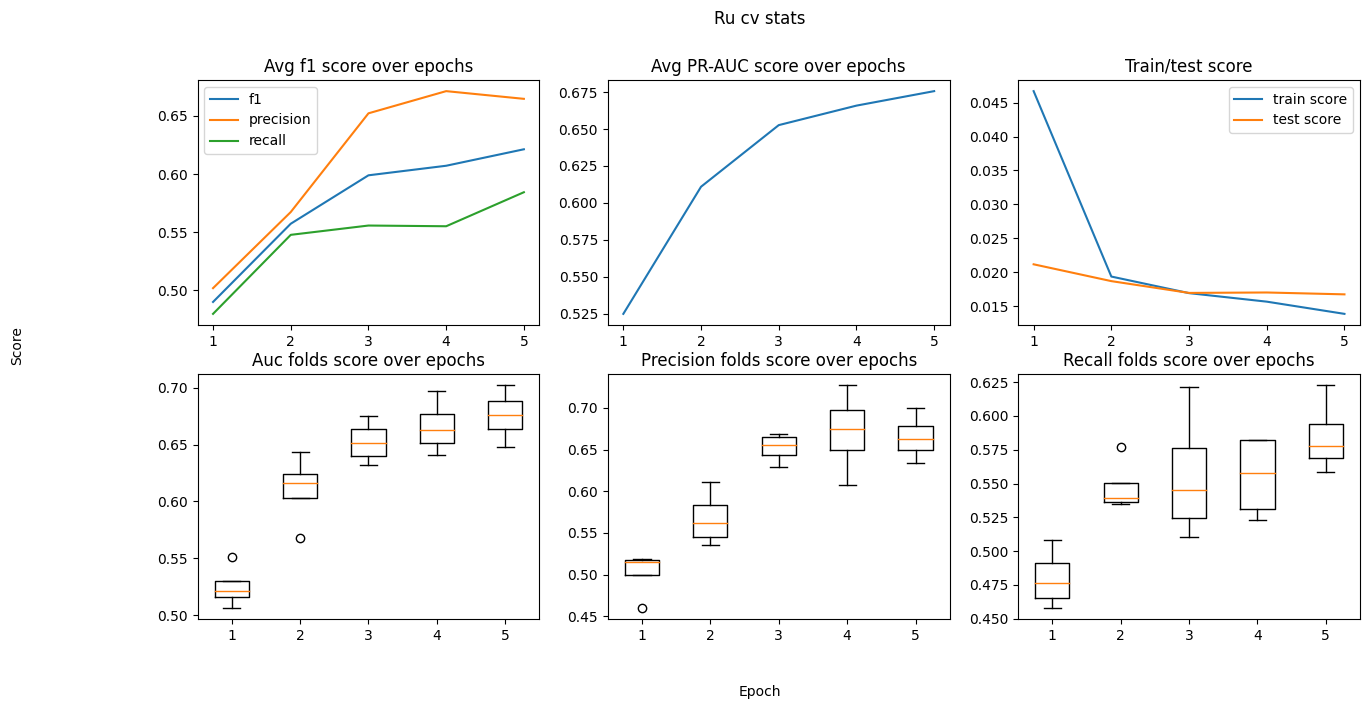

In [30]:
print_stats(ru_fold_metrics, ru_fold_auc, ru_fold_precisions, ru_fold_recalls, ru_fold_train_score, ru_fold_test_score, title='Ru cv stats')

Best epoch numbers:

In [31]:
uk_best_epoch_number, ru_best_epoch_number = np.argmax(uk_avg_auc) + 1, np.argmax(ru_avg_auc) + 1
uk_best_epoch_number, ru_best_epoch_number

(5, 5)

Best thresholds at best epoch:

In [32]:
uk_best_threshold = np.mean(uk_fold_thresholds[uk_best_epoch_number - 1])
ru_best_threshold = np.mean(ru_fold_thresholds[ru_best_epoch_number - 1])
uk_best_threshold, ru_best_threshold

(0.30515036, 0.36706325)

## Training

Training models for best_epoch_number on all train dataset:

In [33]:
def train_model(n_epoch, dataset, embeddor, seq_len):
    train_torch_dataset = TextDataset(
        texts=dataset['tokens'],
        targets=dataset['labels'],
        embeddor=embeddor,
        output_length=seq_len
    )
    train_dataloader = torch.utils.data.DataLoader(
        train_torch_dataset,
        batch_size=64,
        shuffle=True,
        drop_last=True
    )
    
    model, optim, loss_fn = get_train_elements()
    for epoch in range(n_epoch):
        print(f"Epoch {epoch+1}:")
        torch_loop(model, train_dataloader, optim, loss_fn, device=global_device)

    return model, optim, loss_fn

In [34]:
uk_model, uk_optim, uk_loss_fn = train_model(uk_best_epoch_number, uk_train_processed_dataset, uk_embeddor, UK_SEQ_LEN)

Epoch 1:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:25<00:00,  6.15it/s]


Epoch 2:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:25<00:00,  6.08it/s]


Epoch 3:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:25<00:00,  6.12it/s]


Epoch 4:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:25<00:00,  6.15it/s]


Epoch 5:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:26<00:00,  5.91it/s]


In [35]:
ru_model, ru_optim, ru_loss_fn = train_model(ru_best_epoch_number, ru_train_processed_dataset, ru_embeddor, RU_SEQ_LEN)

Epoch 1:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:21<00:00,  5.52it/s]


Epoch 2:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:21<00:00,  5.57it/s]


Epoch 3:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:21<00:00,  5.58it/s]


Epoch 4:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:21<00:00,  5.53it/s]


Epoch 5:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:21<00:00,  5.51it/s]


## Validating on holdout dataset

In [36]:
def val_model(model, optim, loss_fn, dataset, embeddor, seq_len, threshold):
    val_torch_dataset = TextDataset(
        texts = dataset['tokens'],
        targets = dataset['labels'],
        embeddor=embeddor,
        output_length = seq_len
    )
    val_dataloader = torch.utils.data.DataLoader(
        val_torch_dataset,
        batch_size=64
    )
    
    val_pred, val_texts, val_targets, val_losses = torch_loop(model, val_dataloader, optim, loss_fn, device=global_device, is_train=False)
    
    val_metric = calc_metric(val_pred, val_targets, val_texts, val_torch_dataset, th=threshold)
    val_loss = val_losses.mean()
    
    decoded_targets, decoded_texts = decode(val_targets, val_texts, val_torch_dataset, th=threshold)
    decoded_pred, _ = decode(val_pred, val_texts, val_torch_dataset, th=threshold)

    return val_pred, val_metric, val_loss, decoded_texts, decoded_targets, decoded_pred

In [37]:
def print_val_stats(pred, metrics, loss, decoded_texts, decoded_targets, decoded_pred):
    plt.hist(pred.flatten(), bins=10)
    plt.title('Prediction proba distrib')
    plt.show()
    print(f"Holdout metrics: {metrics}")
    print(f"Holdout loss: {loss}")
    print("Holdout texts sample:")
    print(np.array([' '.join(s) for s in decoded_texts[:5]]))
    print("Texts targets:")
    print(decoded_targets[:5])
    print("Texts predicted locations")
    print(decoded_pred[:5])

### Uk model:

In [38]:
(
    uk_val_pred,
    uk_val_metrics,
    uk_val_loss,
    uk_decoded_texts,
    uk_decoded_targets,
    uk_decoded_pred
) = val_model(uk_model, uk_optim, uk_loss_fn, uk_holdout_processed_dataset, uk_embeddor, UK_SEQ_LEN, uk_best_threshold)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:09<00:00, 17.19it/s]


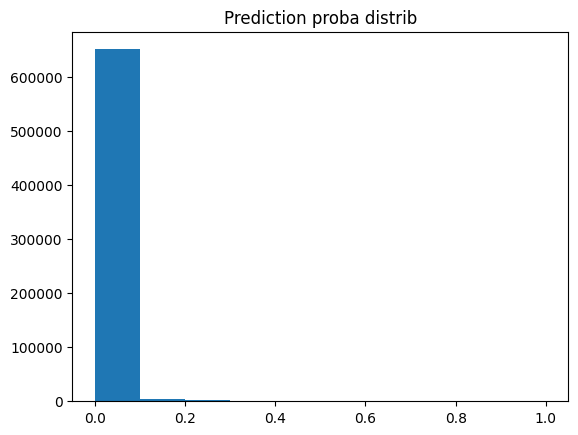

Holdout metrics: {'precision': 0.6054371785451874, 'recall': 0.5103747290182719, 'f1': 0.5538564947067719}
Holdout loss: 0.015750572085380554
Holdout texts sample:
['Один із представників групи противників ЛГБТ у коментарі журналістам заявив , що вони виступають « проти проявів нетрадиційності в сім’ї в Чернівецькій області » .        '
 'Рятувальники загасили загорання , проте досі тліють трава , пеньки та деревина .                    '
 'Але якщо студент не захоче , то його ніхто не зможе навчити .                    '
 'Що ми можемо зробити , щоб обмежити безсимптомний поширення ?                       '
 'Військова операція Туреччини на північному сході Сирії є " вторгненням на територію арабської держави та агресією проти її суверенітету " .            ']
Texts targets:
[['Чернівецькій області'], [], [], [], ['Туреччини', 'Сирії']]
Texts predicted locations
[['Чернівецькій області'], [], [], [], ['Туреччини']]


In [39]:
print_val_stats(uk_val_pred, uk_val_metrics, uk_val_loss, uk_decoded_texts, uk_decoded_targets, uk_decoded_pred)

### Ru model

In [40]:
(
    ru_val_pred,
    ru_val_metrics,
    ru_val_loss,
    ru_decoded_texts,
    ru_decoded_targets,
    ru_decoded_pred
) = val_model(ru_model, ru_optim, ru_loss_fn, ru_holdout_processed_dataset, ru_embeddor, RU_SEQ_LEN, ru_best_threshold)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 475/475 [00:30<00:00, 15.40it/s]


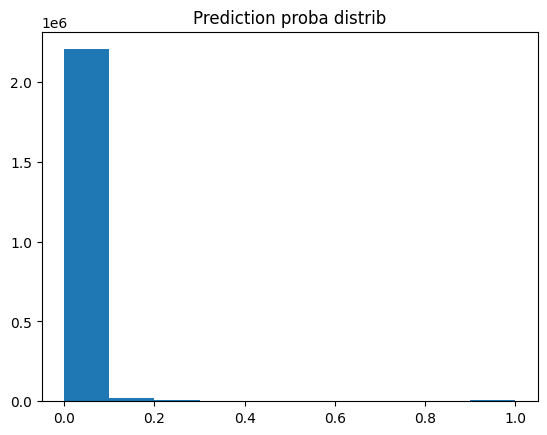

Holdout metrics: {'precision': 0.661409121345138, 'recall': 0.5923112798987274, 'f1': 0.6249560632688927}
Holdout loss: 0.01767970249056816
Holdout texts sample:
['Лидер КПРФ отметил мужество ребят , решивших стать пионерами в столь трудное время .                       '
 'Как сообщили ИТАР - ТАСС в ГУВД столицы , около 14:30 в милицию поступил сигнал о том , что на лестничной площадке дома № 5 по Среднекисловскому переулку обнаружен труп мужчины .     '
 'Между тем за последние выходные в Москве зафиксировано рекордное количество утопленников - 32 человека .                      '
 'После трагической бомбардировки Китай отказался вести переговоры с США о вступлении во Всемирную Торговую Организацию ( ВТО ) .                  '
 'В понедельник около 18:40 в здании московского международного аэропорта " Шереметьево-2 " возник пожар .                      ']
Texts targets:
[[], ['Среднекисловскому переулку'], ['Москве'], ['Китай', 'США'], []]
Texts predicted locations
[[], [], ['Москве'

In [41]:
print_val_stats(ru_val_pred, ru_val_metrics, ru_val_loss, ru_decoded_texts, ru_decoded_targets, ru_decoded_pred)

## Kaggle submission

In [42]:
competition_test = pd.read_csv(DATA_DIR + 'competition/test.csv', converters = {'locations': eval})
labeling_sample = pd.read_csv(DATA_DIR + 'competition/labeling_sample.csv', converters = {'locations': eval})

In [43]:
competition_test.head()

,text_id,text,locations
0,0,"❗️Кількість поранених зросла до трьох, – Кличк...",[]
1,1,"🥤В Києві за 91,13 млн гривень починаються робо...",[]
2,2,▪️Сьогодні вночі росіяни завдали ракетного уда...,[]
3,3,Наразі у запасах росіян найбільше балістичних ...,[]
4,4,"⛸В один день, 29 серпня, ДП ""Центральна учбово...",[]


In [44]:
labeling_sample.head()

,text,locations,loc_markers
0,-261.310,[],[]
1,"Проспект Бандери стоїть, як і пів міста… довго...",[Проспект Бандери],"[(0, 16)]"
2,☢️Радіаційний фон (мкР/год) по Київщині станом...,"[Київщині, Чорнобиль, Київ, Тетерів, Фастів, Б...","[(31, 39), (68, 77), (83, 87), (93, 100), (105..."
3,"Друзі. Останні дві ночі, і ще декілька наступн...",[проспекті Івасюка],"[(134, 151)]"
4,Сьогодні з Києва до Хелма вперше вирушив новий...,"[Києва, Хелма]","[(11, 16), (20, 25)]"


In [45]:
competition_test_tokens, competition_test_locations = tokenize(competition_test['text'].to_list(), competition_test['locations'].to_list(), nlp)

In [46]:
competition_test_processed_dataset = pd.DataFrame({'tokens': competition_test_tokens, 'targets': competition_test_locations})
competition_test_processed_dataset.head()

,tokens,targets
0,"[❗, ️Кількість, поранених, зросла, до, трьох, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O]"
1,"[🥤, В, Києві, за, 91,13, млн, гривень, починаю...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
2,"[▪, ️Сьогодні, вночі, росіяни, завдали, ракетн...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
3,"[Наразі, у, запасах, росіян, найбільше, баліст...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
4,"[⛸, В, один, день, ,, 29, серпня, ,, ДП, "", Це...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."


In [47]:
competition_torch_dataset = TextDataset(
    texts=competition_test_processed_dataset['tokens'],
    targets=competition_test_processed_dataset['targets'],
    embeddor=uk_embeddor,
    output_length=UK_SEQ_LEN
)

competition_dataloader = torch.utils.data.DataLoader(
    competition_torch_dataset,
    batch_size=64
)

competition_pred, competition_texts, _, _ = torch_loop(uk_model, competition_dataloader, uk_optim, uk_loss_fn, device=global_device, is_train=False)

decoded_comp_pred, _ = decode(competition_pred, competition_texts, competition_torch_dataset, uk_best_threshold)
comp_pred_token_spans = [get_token_span(text, tokens) for text, tokens in zip(competition_test['text'].to_list(), decoded_comp_pred)]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 14.31it/s]


In [48]:
competition_test['locations'] = decoded_comp_pred
competition_test['loc_markers'] = comp_pred_token_spans

In [49]:
example_with_many_locations = competition_test.iloc[np.argsort(competition_test['locations'].apply(len)).iloc[-1]]
print(f"""
        Text: {example_with_many_locations['text']},
        Pred locations: {example_with_many_locations['locations']},
        Pred markers: {example_with_many_locations['loc_markers']}
""")


        Text: ❗️У Шевченківському районі Києва сталася пожежа

Загоряння виникло на вул. Димитрівська, 4 в одноповерховій не діючій будівлі о 15:14. Його локалізували на площі 150 кв. м. о 15:37.

Наразі на місці продовжують працювати рятувальники, ліквідація пожежі триває. Попередньо потерпілих немає.
ㅤ,
        Pred locations: [' районі', 'Києва', 'вул. Димитрівська', 'одноповерховій', 'площі'],
        Pred markers: [(19, 25), (27, 31), (70, 86), (93, 106), (156, 160)]



In [50]:
competition_test[['text_id', 'locations']].to_csv(DATA_DIR + 'competition/submission/uk_word2vec_rnn_simple.csv')

## Competition score

Score after training model on all uk dataset for 5 epochs:

![title](images/location_detection_score.png)

There are three posible reasons why competition score is much lower then validation score: competition texts is much more difficult, model was overfited,
or that decoding predictions to tokens is incorect.

Problem with decoding might not be noticeable in validation, because targets and predictions are decoded with the same function,
but competition targets are decoded in a different way.